In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

from scipy.optimize import minimize, differential_evolution,\
               NonlinearConstraint, LinearConstraint, Bounds
from statistics import *
import pytz
import arrow
import ccxt
from ccxt import deribit

## Data Pulling

In [2]:
df_trade = pd.read_csv("Feb22-Options-Data.csv")

In [3]:
df_trade.head(5)

,best_bid_amount,best_ask_amount,estimated_delivery_price,bid_iv,ask_iv,underlying_index,underlying_price,mark_iv,best_bid_price,best_ask_price,interest_rate,open_interest,max_price,min_price,last_price,settlement_price,instrument_name,mark_price,index_price,state,timestamp,date_time,expiry,strike_price,option_type,bs_rho,bs_theta,bs_vega,bs_gamma,bs_delta,volume,volume_usd,days_to_expiry,yrs_to_expiry,futures_price,log_strike,atm_iv,ITM,adj_iv
0,4.0,2.6,51649.28,0.8850,0.9624,SYN.BTC-24FEB24,51662.8543,0.9279,0.0001,0.0002,0.0,54.9,0.015,0.0001,0.0002,0.000179,BTC-24FEB24-45000-P,0.0001,51649.28,open,1708639667840,2024-02-22T22:07:47.840Z,2024-02-24 23:59:59,45000,P,-0.01571,-7.71915,0.68197,0.00001,-0.00771,52.2,976.26,2,0.005476,51644.133333,-0.137714,0.52185,False,0.873468
1,20.1,15.7,51649.28,0.7582,0.9121,SYN.BTC-24FEB24,51662.8543,0.8283,0.0001,0.0004,0.0,57.7,0.015,0.0001,0.0004,0.000289,BTC-24FEB24-46000-P,0.0002,51649.28,open,1708639667840,2024-02-22T22:07:47.840Z,2024-02-24 23:59:59,46000,P,-0.02298,-10.49551,0.95236,0.00001,-0.01130,46.9,978.81,2,0.005476,51644.133333,-0.115735,0.52185,False,0.813682
2,8.6,7.4,51649.28,0.7327,0.8192,SYN.BTC-24FEB24,51662.8543,0.7577,0.0003,0.0006,0.0,18.7,0.017,0.0001,0.0006,0.000564,BTC-24FEB24-47000-P,0.0004,51649.28,open,1708639667840,2024-02-22T22:07:47.840Z,2024-02-24 23:59:59,47000,P,-0.04290,-19.29580,1.62795,0.00002,-0.02111,5.5,184.03,2,0.005476,51644.133333,-0.094229,0.52185,False,0.751436
3,6.1,7.7,51649.28,0.6927,0.7633,SYN.BTC-24FEB24,51662.8543,0.7112,0.0004,0.0007,0.0,55.7,0.018,0.0001,0.0005,0.000763,BTC-24FEB24-47500-P,0.0005,51649.28,open,1708639667840,2024-02-22T22:07:47.840Z,2024-02-24 23:59:59,47500,P,-0.05547,-24.21774,2.02105,0.00003,-0.02730,13.9,556.28,2,0.005476,51644.133333,-0.083647,0.52185,False,0.719345
4,8.9,12.7,51649.16,0.6435,0.7190,SYN.BTC-24FEB24,51663.1057,0.6716,0.0005,0.0009,0.0,11.7,0.019,0.0001,0.0008,0.001057,BTC-24FEB24-48000-P,0.0006,51649.16,open,1708639668848,2024-02-22T22:07:48.848Z,2024-02-24 23:59:59,48000,P,-0.07592,-32.71789,2.61943,0.00004,-0.03738,8.6,568.70,2,0.005476,51644.133333,-0.073176,0.52185,False,0.686645


## Arbitrage-free Smiles Fitting

In [4]:
def ftotal_var_ssvi(k, rho, phi, theta):
    return 1/2 * theta * (1 + rho * phi * k + np.sqrt(np.square(phi * k + rho) + (1 - np.square(rho))))

def SSVIsolver(k, mat, mkt_vol, sigma):
    # Surface-SVI
    
    theta = sigma ** 2 * mat

    def objFunc(x):
        # power law - see Gatheral and Jacquire
        rho, eta, gamma1, gamma2, beta1, beta2 = x
        phi = eta/(theta ** gamma1 * (1 + beta1 * theta) ** gamma2 * (1 + beta2 * theta) ** (1 - gamma1 - gamma2))
        adj_vol = np.sqrt(ftotal_var_ssvi(k, rho, phi, theta) / mat)
       
        return np.sum(100 * np.square(adj_vol - mkt_vol)) # mult. by 100 to help with convergence

    def constraintFunc1(x): # arbitrage free
        rho, eta, gamma1, gamma2, beta1, beta2 = x
        # return 4 * gamma -  np.abs(rho)
        return eta * (1 + np.abs(rho)) 

    def constraintFunc2(x):
        rho, eta, gamma1, gamma2, beta1, beta2 = x
        phi = eta / (theta ** gamma1 * (1 + beta1 * theta) ** gamma2 * (1 + beta2 * theta) ** (1- gamma1 - gamma2))
        return theta * phi * (1 + np.abs(rho))

    def constraintFunc3(x):
        rho, eta, gamma1, gamma2, beta1, beta2 = x
        phi = eta / (theta ** gamma1 * (1 + beta1 * theta) ** gamma2 * (1 + beta2 * theta) ** (1- gamma1 - gamma2))
        return theta * np.square(phi) * (1 + np.abs(rho))

    def constraintFunc4(x): # sanity-check: positive variance
        rho, eta, gamma1, gamma2, beta1, beta2 = x
        phi = eta/(theta ** gamma1 * (1 + beta1 * theta) ** gamma2 * (1 + beta2 * theta) ** (1 - gamma1 - gamma2))
        return ftotal_var_ssvi(k, rho, phi, theta)

    res = minimize(
               objFunc,
               x0 = [-1e-2, 1., .5, .5, 5., 80.],
               method = 'SLSQP',
               bounds = [(-1., 1.), (1e-5, 2.), (-np.inf, np.inf), (1e-5, np.inf), (1e-5, np.inf), (1e-5, np.inf)],
               constraints = [
                              NonlinearConstraint(constraintFunc1, -np.inf, 2.), 
                              NonlinearConstraint(constraintFunc2, -np.inf, 4.),
                              NonlinearConstraint(constraintFunc3, -np.inf, 4.),
                              NonlinearConstraint(constraintFunc4, 0, np.inf),
               ], 
               options = {'disp':True,'maxiter':700},
               tol=5e-10)
    return res

def ftotal_var_nsvi(k, delta, mu, rho, omega, phi): # total variance in natural-SVI model
    return delta + 1/2 * omega * (1 + phi * rho * (k - mu) + \
                                  np.sqrt(np.square(phi * (k - mu) + rho) + (1 - np.square(rho))))

def nSVIsolver(k, mat, market_vol, init_guess): # solve and return nSVI params per slice

    def objFunc(x):
        delta, mu, rho, omega, phi = x
        adj_vol = np.sqrt(ftotal_var_nsvi(k, delta, mu, rho, omega, phi) / mat)

        return np.sum(100 * np.square(adj_vol - market_vol))

    def constraintFunc(x): # sanity-check: positive variance
        delta, mu, rho, omega, phi = x
        return ftotal_var_nsvi(k, delta, mu, rho, omega, phi)

    init_rho, init_omega, init_phi = init_guess

    res  = minimize(
                objFunc,
                x0 = [0., 4e-3, init_rho, init_omega, init_phi],
                method = 'SLSQP',
                bounds = [(-1., 1.), (-1., 1.), 
                          (init_rho - 1e-3, init_rho + 1e-3), (0.95 * init_omega, 1.05 * init_omega), 
                          (0.95 * init_phi, 1.05 * init_phi)],
                constraints = [NonlinearConstraint(constraintFunc, 0., np.inf)],
                options = {'disp':True,'maxiter':700},
                tol=5e-10)
    
    return res

def SVIfitting(df):
    res = SSVIsolver(df.log_strike, df.yrs_to_expiry, df.mark_iv, 
                     df.atm_iv)
    x = res.x
    print(res)

    theta = (lambda sigma, t: sigma ** 2 * t)(df.atm_iv, df.yrs_to_expiry)

    ## power-law model
    rho, eta, gamma1, gamma2, beta1, beta2 = x
    phi = eta / (theta ** gamma1 * (1 + beta1 * theta) ** gamma2 * (1 + beta2 * theta) ** (1- gamma1 - gamma2))
    
    temp_adj_vol = []
    params_dict = {}

    for dy, yr, init_theta, init_phi in zip(df_trade.days_to_expiry.unique(), 
                                            df_trade.yrs_to_expiry.unique(), 
                                            theta.unique(), phi.unique()):
        
        k = df[df.days_to_expiry == dy].log_strike
        market_vol = df[df.days_to_expiry == dy].mark_iv
        
        res = nSVIsolver(k, yr, market_vol, (rho, init_theta, init_phi))
        args = res.x
        print(f"params on day {dy}:", res.x) 
        
        temp_adj_vol.extend(np.sqrt(ftotal_var_nsvi(k, *args) / yr))
        params_dict[dy] = [*args]

    df["adj_iv"] = temp_adj_vol

    return df, params_dict
   

In [5]:
df_trade, params_dict = SVIfitting(df_trade)

/Users/longvu/miniconda3/envs/backtest/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 26.66006976785982
            Iterations: 163
            Function evaluations: 1210
            Gradient evaluations: 163
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 26.66006976785982
       x: [-9.993e-03  2.281e-02  1.071e+00  2.910e+00  5.723e+01
            1.290e+02]
     nit: 163
     jac: [-5.596e-03 -7.943e-01 -1.205e-01 -9.049e-03  4.239e-04
           -6.843e-05]
    nfev: 1210
    njev: 163
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.1351882489724658
            Iterations: 10
            Function evaluations: 70
            Gradient evaluations: 10
params on day 2: [-2.12333862e-04 -1.80037433e-03 -1.09931132e-02  1.56574288e-03
  3.26091849e+01]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.1504846680076972
            Iterations: 19
            Functi

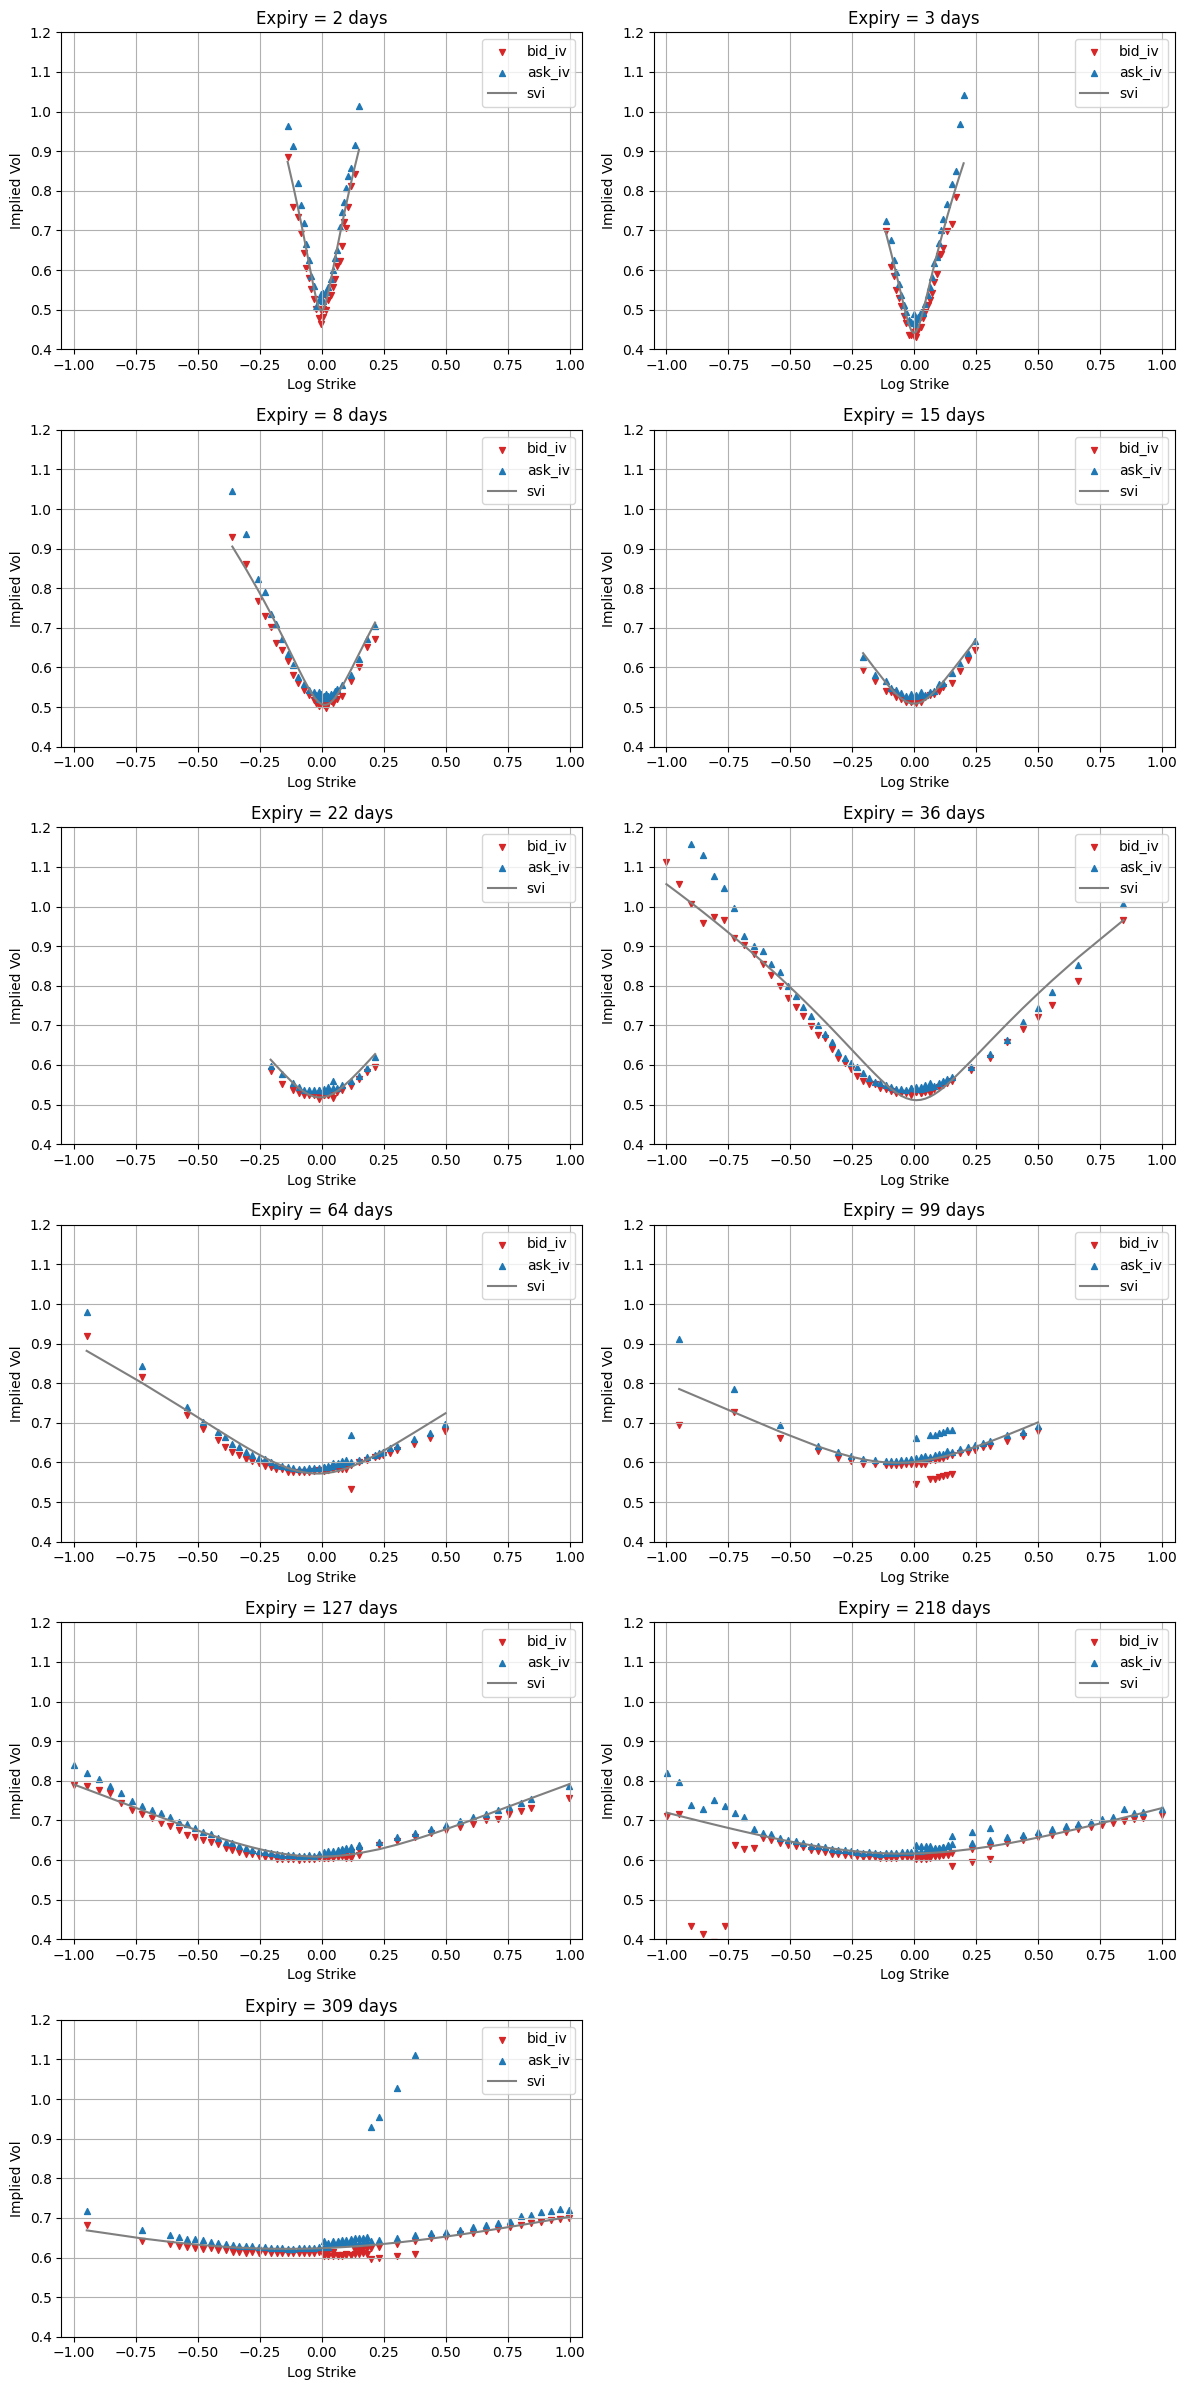

In [6]:
num_rows = (df_trade.days_to_expiry.unique().shape[0] + 1) // 2
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows*4))

# Flatten the axes if num_rows > 1
axes = axes.flatten()

# Plot data for each day
for i, day in enumerate(df_trade.days_to_expiry.unique()):
    df_day = df_trade[df_trade.days_to_expiry == day].sort_values("log_strike")
    ax = axes[i]
    ax.scatter(df_day.log_strike, df_day.bid_iv, \
               marker = 'v', color = "tab:red", s = 18, label = 'bid_iv')
    ax.scatter(df_day.log_strike, df_day.ask_iv, \
               marker = '^', color = "tab:blue", s = 18, label = 'ask_iv')
    ax.plot(df_day.log_strike, df_day.adj_iv, color='tab:grey', label = 'svi')
    ax.set_title(f"Expiry = {day} days")
    ax.set_xlabel("Log Strike")
    ax.set_ylabel("Implied Vol")
    ax.set_xlim(-1.05, 1.05)
    ax.set_ylim(0.4, 1.2)
    ax.legend()
    ax.grid(True)

# Hide any extra subplots
for i in range(df_trade.days_to_expiry.unique().shape[0], num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()
